## This notebook shows how to use Orchestrator APIs for user experiments

In [53]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [54]:
ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

In [55]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"FABRIC Orchestrator         : {orchestrator_host}")

FABRIC Credential Manager   : cm.fabric-testbed.net
FABRIC Orchestrator         : orchestrator.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [56]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [57]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: MAX: { cpu: 10/10 , core: 312/320 , ram: 2,536/2,560 G, disk: 116,360/116,400 G, unit: 5/5 }
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 633/635 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 3/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 1/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		NVME-P4510:  NVME P4510 { disk: 14,400/15,360 G, unit: 15/16 }
	Site Interfaces:
		MAX_TACC: TrunkPort { bw: 100/100 Gbps}
		MAX_STAR: TrunkPort { bw: 100/100 Gbps}
MICH: { cpu: 6/6 , core: 192/192 , ram: 1,536/1,536 G, disk: 60,600/60,600 G, unit: 3/3 }
	Components:
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		NVME-P4510:  NVME P4510 { disk: 9,600/9,600 G, unit: 10/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	S

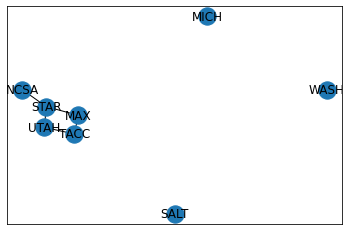

In [58]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice
In Release 1.0, user is expected to assign the IP addresses manually. Please use the example comands indicated below:

## Configure Slice Parameters



In [59]:
slice_name = 'MySliceL2Bridge'
site = 'MAX'
node1_name = 'Node1'
node2_name = 'Node2'
network_service_name='bridge1'
nic1_name = 'node1-nic1'
nic2_name = 'node2-nic1'
image = 'default_centos_8'
image_type = 'qcow2'
cores = 2
ram = 16
disk = 100

In [60]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name=node1_name, site=site)

# Set capacities
cap = Capacities()
cap.set_fields(core=cores, ram=ram, disk=disk)

# Set Properties
n1.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Add node
n2 = t.add_node(name=node2_name, site=site)

# Set properties
n2.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Shared Cards
n1.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name=nic1_name)
n2.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name=nic2_name)

# L2Bridge Service
t.add_network_service(name=network_service_name, nstype=ServiceType.L2Bridge, interfaces=t.interface_list)

# Generate Slice Graph
slice_graph = t.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, 
                                            slice_graph=slice_graph, 
                                            ssh_key=ssh_key_pub)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")

Submitted slice creation request. Slice ID: 4e00e758-9da7-4c27-8b6c-4021fa2fac6d


## Get the Slice

In [62]:
import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice    


return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

if return_status == Status.OK:
    slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
    slice = wait_for_slice(slice, progress=True)

print()
print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice . Slice state: StableOK

Slice Name : MySliceL2Bridge
ID         : 4e00e758-9da7-4c27-8b6c-4021fa2fac6d
State      : StableOK
Lease End  : 2021-10-20 11:41:10


## Get the Nodes

Retrieve the node information and save the management IP address.


### Get the Topology

In [63]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

### Configure Node1

Use ssh to configure eth1 on  node 1.  

```
ip addr add 192.168.10.51/24 dev eth1
```

In [64]:
node1 = experiment_topology.nodes[node1_name]

management_ip_node1 = str(node1.get_property(pname='management_ip'))
print("Node Name        : {}".format(node1.name))
print("Management IP    : {}".format(management_ip_node1))
print()


Node Name        : Node1
Management IP    : 63.239.135.114



In [65]:
import paramiko

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(management_ip_node1,username='centos',pkey = key)

stdin, stdout, stderr = client.exec_command('sudo ip addr add 192.168.10.51/24 dev eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

stdin, stdout, stderr = client.exec_command('ifconfig eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))



eth1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 192.168.10.51  netmask 255.255.255.0  broadcast 0.0.0.0
        ether 66:cd:33:13:aa:d7  txqueuelen 1000  (Ethernet)
        RX packets 0  bytes 0 (0.0 B)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 60  bytes 10488 (10.2 KiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0




### Configure Node2

Use ssh to configure eth1 on each Node 2.  

```
ip addr add 192.168.10.52/24 dev eth1
```

In [66]:
node2 = experiment_topology.nodes[node2_name]

management_ip_node2 = str(node2.get_property(pname='management_ip'))
print("Node Name        : {}".format(node2.name))
print("Management IP    : {}".format(management_ip_node2))
print()


Node Name        : Node2
Management IP    : 63.239.135.102



In [68]:
import paramiko

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(management_ip_node2,username='centos',pkey = key)

stdin, stdout, stderr = client.exec_command('sudo ip addr add 192.168.10.52/24 dev eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))

stdin, stdout, stderr = client.exec_command('ifconfig eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))



eth1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 192.168.10.52  netmask 255.255.255.0  broadcast 0.0.0.0
        ether b2:a0:36:22:bb:0e  txqueuelen 1000  (Ethernet)
        RX packets 0  bytes 0 (0.0 B)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 61  bytes 10578 (10.3 KiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0




## Delete Slice

In [69]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
